In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn

import yfinance as yf

data = yf.download("^GSPC", start="1980-01-01", end="2025-02-09")
data.reset_index(inplace=True)

# Caso o DataFrame tenha um MultiIndex, remover os níveis extras
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # Remove o primeiro nível do índice

#data = pd.read_csv('AMZN.csv')

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,1980-01-02,105.760002,108.430000,105.290001,0.000000,40610000
1,1980-01-03,105.220001,106.080002,103.260002,0.000000,50480000
2,1980-01-04,106.519997,107.080002,105.089996,0.000000,39130000
3,1980-01-07,106.809998,107.800003,105.800003,0.000000,44500000
4,1980-01-08,108.949997,109.290001,106.290001,0.000000,53390000
...,...,...,...,...,...,...
11365,2025-02-03,5994.569824,6022.129883,5923.930176,5969.649902,4797210000
11366,2025-02-04,6037.879883,6042.479980,5990.870117,5998.140137,4410160000
11367,2025-02-05,6061.479980,6062.859863,6007.060059,6020.450195,4756250000
11368,2025-02-06,6083.569824,6084.029785,6046.830078,6072.220215,4847120000


In [3]:
data = data[['Date', 'Close']]
data

Price,Date,Close
0,1980-01-02,105.760002
1,1980-01-03,105.220001
2,1980-01-04,106.519997
3,1980-01-07,106.809998
4,1980-01-08,108.949997
...,...,...
11365,2025-02-03,5994.569824
11366,2025-02-04,6037.879883
11367,2025-02-05,6061.479980
11368,2025-02-06,6083.569824


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #Diz para usar GPU caso exista, se não existir, cpu
device

'cpu'

/tmp/ipykernel_2236/1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


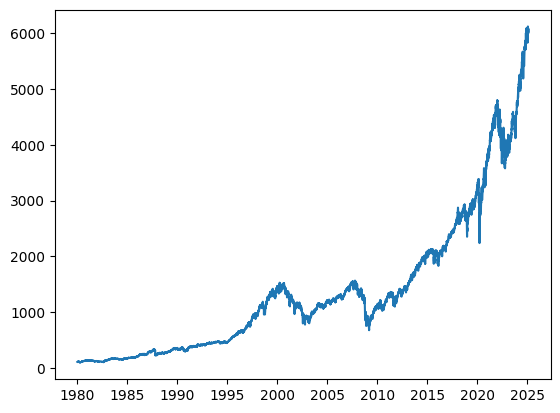

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [6]:
from copy import deepcopy as dc 

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29),Close(t-30)
Date,,,,,,,,,,,,,,,,,,,,,
1980-02-13,118.440002,117.900002,117.120003,117.949997,116.279999,115.720001,114.660004,114.370003,115.120003,114.160004,...,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998,106.519997,105.220001,105.760002
1980-02-14,116.720001,118.440002,117.900002,117.120003,117.949997,116.279999,115.720001,114.660004,114.370003,115.120003,...,111.050003,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998,106.519997,105.220001
1980-02-15,115.410004,116.720001,118.440002,117.900002,117.120003,117.949997,116.279999,115.720001,114.660004,114.370003,...,110.699997,111.050003,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998,106.519997
1980-02-19,114.599998,115.410004,116.720001,118.440002,117.900002,117.120003,117.949997,116.279999,115.720001,114.660004,...,111.070000,110.699997,111.050003,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998
1980-02-20,116.470001,114.599998,115.410004,116.720001,118.440002,117.900002,117.120003,117.949997,116.279999,115.720001,...,112.099998,111.070000,110.699997,111.050003,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03,5994.569824,6040.529785,6071.169922,6039.310059,6067.700195,6012.279785,6101.240234,6118.709961,6086.370117,6049.240234,...,5881.629883,5906.939941,5970.839844,6037.589844,6040.040039,5974.069824,5930.850098,5867.080078,5872.160156,6050.609863
2025-02-04,6037.879883,5994.569824,6040.529785,6071.169922,6039.310059,6067.700195,6012.279785,6101.240234,6118.709961,6086.370117,...,5868.549805,5881.629883,5906.939941,5970.839844,6037.589844,6040.040039,5974.069824,5930.850098,5867.080078,5872.160156
2025-02-05,6061.479980,6037.879883,5994.569824,6040.529785,6071.169922,6039.310059,6067.700195,6012.279785,6101.240234,6118.709961,...,5942.470215,5868.549805,5881.629883,5906.939941,5970.839844,6037.589844,6040.040039,5974.069824,5930.850098,5867.080078


In [7]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 118.44000244,  117.90000153,  117.12000275, ...,  106.51999664,
         105.22000122,  105.76000214],
       [ 116.72000122,  118.44000244,  117.90000153, ...,  106.80999756,
         106.51999664,  105.22000122],
       [ 115.41000366,  116.72000122,  118.44000244, ...,  108.94999695,
         106.80999756,  106.51999664],
       ...,
       [6061.47998047, 6037.87988281, 5994.56982422, ..., 5974.06982422,
        5930.85009766, 5867.08007812],
       [6083.56982422, 6061.47998047, 6037.87988281, ..., 6040.04003906,
        5974.06982422, 5930.85009766],
       [6025.99023438, 6083.56982422, 6061.47998047, ..., 6037.58984375,
        6040.04003906, 5974.06982422]])

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99328294, -0.99346233, -0.99372144, ..., -0.99722966,
        -0.99766357, -0.99748333],
       [-0.99385432, -0.99328294, -0.99346233, ..., -0.99713287,
        -0.99722966, -0.99766357],
       [-0.9942895 , -0.99385432, -0.99328294, ..., -0.99641859,
        -0.99713287, -0.99722966],
       ...,
       [ 0.98098826,  0.97314834,  0.95876079, ...,  0.96121521,
         0.94678952,  0.92550465],
       [ 0.98832649,  0.98098826,  0.97314834, ...,  0.98323446,
         0.96121521,  0.94678952],
       [ 0.96919861,  0.98832649,  0.98098826, ...,  0.98241664,
         0.98323446,  0.96121521]])

In [9]:
x = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

x.shape, y.shape

((11340, 30), (11340,))

In [10]:
x = dc(np.flip(x, axis=1))
x

array([[-0.99748333, -0.99766357, -0.99722966, ..., -0.99344572,
        -0.99372144, -0.99346233],
       [-0.99766357, -0.99722966, -0.99713287, ..., -0.99372144,
        -0.99346233, -0.99328294],
       [-0.99722966, -0.99713287, -0.99641859, ..., -0.99346233,
        -0.99328294, -0.99385432],
       ...,
       [ 0.92550465,  0.94678952,  0.96121521, ...,  0.97402863,
         0.95876079,  0.97314834],
       [ 0.94678952,  0.96121521,  0.98323446, ...,  0.95876079,
         0.97314834,  0.98098826],
       [ 0.96121521,  0.98323446,  0.98241664, ...,  0.97314834,
         0.98098826,  0.98832649]])

In [11]:
split_index = int(len(x) * 0.95)
split_index

10773

In [12]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train =y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10773, 30), (567, 30), (10773,), (567,))

In [13]:
x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10773, 30, 1), (567, 30, 1), (10773, 1), (567, 1))

In [14]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([10773, 30, 1]),
 torch.Size([567, 30, 1]),
 torch.Size([10773, 1]),
 torch.Size([567, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [16]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 30, 1]) torch.Size([16, 1])


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 100, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [20]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [21]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.071
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 60

In [22]:
print(y_train)

tensor([[-0.9933],
        [-0.9939],
        [-0.9943],
        ...,
        [ 0.2536],
        [ 0.2484],
        [ 0.2163]])


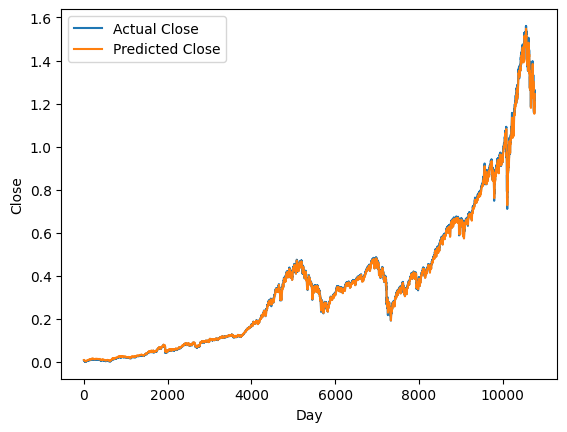

In [23]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()


plt.plot(y_train+1, label='Actual Close')
plt.plot(predicted+1, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 125.56825497,  126.06149314,  125.82877946, ..., 3829.08003794,
       3841.94083318, 3842.56074511])

In [25]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

/tmp/ipykernel_2236/2743067881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([ 118.44007514,  116.71993167,  115.40995279, ..., 3871.98000711,
       3856.10007927, 3759.68995795])

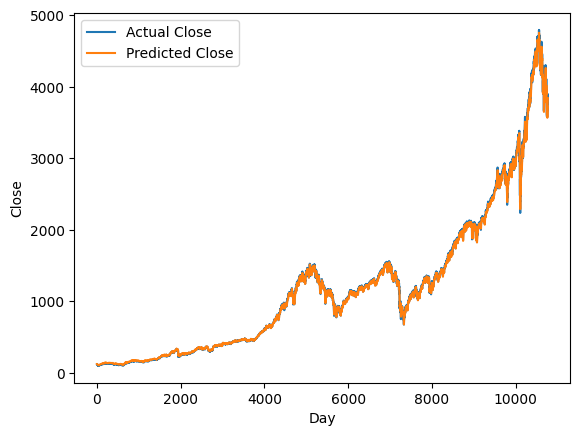

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [27]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([3808.07179668, 3758.51405409, 3732.81556453, 3734.45070561,
       3754.04732396, 3751.28844672, 3807.05988689, 3876.45207512,
       3921.02490938, 3953.8572755 , 3959.89975717, 3949.27082431,
       3940.1077903 , 3928.80081195, 3937.31719976, 3958.05688728,
       3977.79412965, 3972.51474073, 3957.5220226 , 3979.93322953,
       4007.37496348, 4028.87289928, 4019.38115943, 3983.06149713,
       3944.00004777, 3923.74103871, 3907.82069549, 3917.41381023,
       3942.93713654, 3960.22828358, 3938.99499904, 3896.01455795,
       3845.2287438 , 3807.36414613, 3803.59977353, 3797.23728811,
       3801.2508366 , 3802.83699477, 3789.00968416, 3794.10161925,
       3800.35330998, 3801.31995992, 3809.17987805, 3802.72359843,
       3820.44558875, 3839.66873483, 3863.22615085, 3896.78410998,
       3927.789575  , 3953.50219425, 3966.41412549, 3950.86644713,
       3919.62790958, 3913.67747272, 3932.77219566, 3956.04194922,
       3975.12160049, 4000.56813309, 4023.00284463, 4021.09663

In [28]:
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_2236/973696869.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([3719.8899073 , 3770.55003453, 3806.80003524, 3828.1101135 ,
       3748.57007458, 3956.37011678, 3992.92993889, 3957.25001493,
       3991.72994728, 3958.79001612, 3946.56007772, 3965.34008994,
       3949.93989858, 4003.58004384, 4027.26005171, 4026.12007762,
       3963.93995021, 3957.62985677, 4080.11010082, 4076.5700538 ,
       4071.69993235, 3998.84009493, 3941.25996526, 3933.919885  ,
       3963.51004891, 3934.37983992, 3990.560099  , 4019.64993746,
       3995.32005375, 3895.7499964 , 3852.36010841, 3817.65993239,
       3821.62010207, 3878.43992007, 3822.38987838, 3844.82005946,
       3829.24999788, 3783.21996687, 3849.28001631, 3839.49998601,
       3824.13989605, 3852.96997257, 3808.10010091, 3895.08011472,
       3892.09009376, 3919.25004141, 3969.61012587, 3983.16995929,
       3999.09012309, 3990.96999446, 3928.86011177, 3898.85009434,
       3972.6101049 , 4019.8100739 , 4016.94995634, 4016.21996742,
       4060.42991546, 4070.56004798, 4017.77001639, 4076.60010

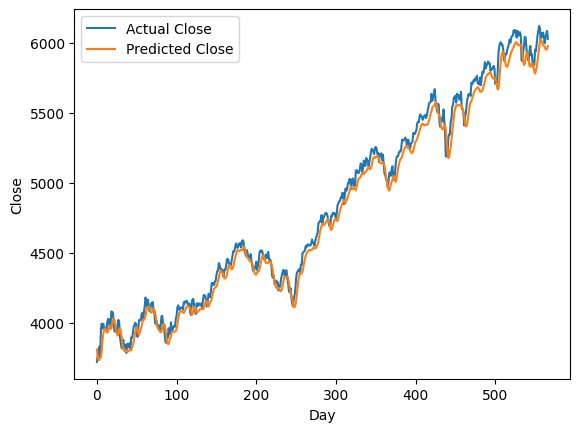

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [30]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions


dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_2236/2457523599.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([3719.8899073 , 3770.55003453, 3806.80003524, 3828.1101135 ,
       3748.57007458, 3956.37011678, 3992.92993889, 3957.25001493,
       3991.72994728, 3958.79001612, 3946.56007772, 3965.34008994,
       3949.93989858, 4003.58004384, 4027.26005171, 4026.12007762,
       3963.93995021, 3957.62985677, 4080.11010082, 4076.5700538 ,
       4071.69993235, 3998.84009493, 3941.25996526, 3933.919885  ,
       3963.51004891, 3934.37983992, 3990.560099  , 4019.64993746,
       3995.32005375, 3895.7499964 , 3852.36010841, 3817.65993239,
       3821.62010207, 3878.43992007, 3822.38987838, 3844.82005946,
       3829.24999788, 3783.21996687, 3849.28001631, 3839.49998601,
       3824.13989605, 3852.96997257, 3808.10010091, 3895.08011472,
       3892.09009376, 3919.25004141, 3969.61012587, 3983.16995929,
       3999.09012309, 3990.96999446, 3928.86011177, 3898.85009434,
       3972.6101049 , 4019.8100739 , 4016.94995634, 4016.21996742,
       4060.42991546, 4070.56004798, 4017.77001639, 4076.60010

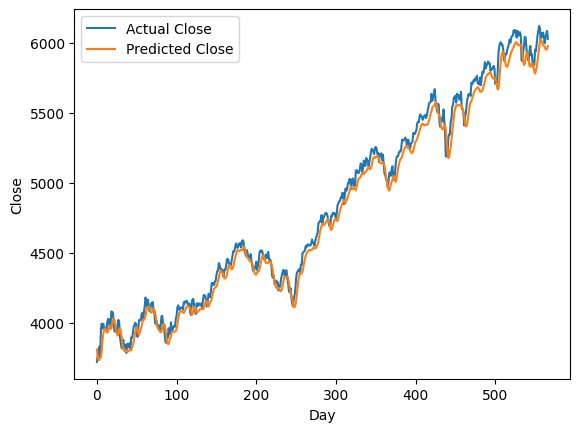

In [31]:

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [32]:
##############################
# Tentar implementar as news #
##############################

In [33]:
import yfinance as yf
from datetime import datetime

stock_symbol = "AAPL"  # Pode ser qualquer ação
ticker = yf.Ticker(stock_symbol)


# Recebe as 10 notícias mais recentes
news = ticker.news 


for article in news:
    if (int(article['content']['pubDate'][8:10]) == datetime.today().day \
    or int(article['content']['pubDate'][8:10]) == datetime.today().day - 1) \
    and int(article['content']['pubDate'][5:7]) == datetime.today().month \
    and int(article['content']['pubDate'][:4]) == datetime.today().year:
        print(f"Data publicação: {article['content']['pubDate']}")
        print(f"Título: {article['content']['title']}")
        print(article['content']['summary'])
        print(f"URL: {article['content']['canonicalUrl']['url']}")

    print("-" * 50)

#ticker.actions
#ticker.financials

Data publicação: 2025-02-23T14:55:59Z
Título: Silicon Valley is going all in on humanoid robots. Making them a reality will take decades.
Silicon Valley is working to make humanoid robots a reality. But getting there will take time.
URL: https://finance.yahoo.com/news/silicon-valley-is-going-all-in-on-humanoid-robots-making-them-a-reality-will-take-decades-145559940.html
--------------------------------------------------
Data publicação: 2025-02-24T08:34:00Z
Título: Prediction: 2 AI Stocks Will Be Worth More Than Apple Stock by the Year's End in 2025
Currently, Apple is the most valuable publicly traded company, with a market value of $3.6 trillion.  Among the 68 analysts following Nvidia, the average target price is $175 per share.  It also implies a market value of $4.3 trillion.
URL: https://www.fool.com/investing/2025/02/24/2-ai-stocks-worth-more-than-apple-stock-in-2025/?source=eptyholnk0000202&utm_source=yahoo-host-full&utm_medium=feed&utm_campaign=article&referring_guid=a25120fc

In [34]:
import pandas as pd
from datetime import datetime


# Criar um DataFrame com as notícias e datas
news_data = []
for article in news:
    display_time = article['content'].get('displayTime', '')  # Evita KeyError
    try:
        date_parsed = datetime.strptime(display_time, "%Y-%m-%dT%H:%M:%SZ") if display_time else None
    except ValueError:
        date_parsed = None  # Caso a string tenha um formato inválido
    if date_parsed != None:
        news_data.append({
            "title": article['content']["title"],
            "link": article['content']['canonicalUrl']['url'],
            "content": article['content']['summary'],
            "date": date_parsed,  # Converter string para datetime
            "publisher": article['content']['provider']['displayName']
        })

news_df = pd.DataFrame(news_data)
print(news_df.head())
news_df


                                               title  \
0  Silicon Valley is going all in on humanoid rob...   
1  Prediction: 2 AI Stocks Will Be Worth More Tha...   
2  Alibaba to Spend More Than $52 Billion in AI, ...   
3  Apple Inc. (AAPL): Among Renaissance Technolog...   
4  Is Apple Inc. (AAPL) the Top Stock to Buy Acco...   

                                                link  \
0  https://finance.yahoo.com/news/silicon-valley-...   
1  https://www.fool.com/investing/2025/02/24/2-ai...   
2  https://www.wsj.com/tech/ai/alibaba-to-spend-m...   
3  https://finance.yahoo.com/news/apple-inc-aapl-...   
4  https://finance.yahoo.com/news/apple-inc-aapl-...   

                                             content                date  \
0  Silicon Valley is working to make humanoid rob... 2025-02-24 08:35:02   
1  Currently, Apple is the most valuable publicly... 2025-02-24 08:34:00   
2  The Chinese technology giant first mentioned t... 2025-02-24 07:42:00   
3  We recently publish

,title,link,content,date,publisher
0,Silicon Valley is going all in on humanoid rob...,https://finance.yahoo.com/news/silicon-valley-...,Silicon Valley is working to make humanoid rob...,2025-02-24 08:35:02,Yahoo Finance
1,Prediction: 2 AI Stocks Will Be Worth More Tha...,https://www.fool.com/investing/2025/02/24/2-ai...,"Currently, Apple is the most valuable publicly...",2025-02-24 08:34:00,Motley Fool
2,"Alibaba to Spend More Than $52 Billion in AI, ...",https://www.wsj.com/tech/ai/alibaba-to-spend-m...,The Chinese technology giant first mentioned t...,2025-02-24 07:42:00,The Wall Street Journal
3,Apple Inc. (AAPL): Among Renaissance Technolog...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently published a list of Renaissance Te...,2025-02-23 18:20:38,Insider Monkey
4,Is Apple Inc. (AAPL) the Top Stock to Buy Acco...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently published a list of Top 10 Stocks ...,2025-02-23 13:58:27,Insider Monkey
5,"If You Invested $10,000 in Apple Stock 30 Year...",https://www.fool.com/investing/2025/02/23/if-y...,All investors dream about finding that one sto...,2025-02-23 13:20:00,Motley Fool
6,Apple needs the iPhone 16e to be a hit. Here’s...,https://www.cnn.com/2025/02/23/tech/apple-ipho...,Apple’s iPhone 16e debut was surprising for tw...,2025-02-23 14:38:56,CNN Business
7,"Is Apple a Buy, Sell, or Hold in 2025?",https://www.fool.com/investing/2025/02/23/is-a...,"With a market capitalization of $3.7 trillion,...",2025-02-23 11:30:00,Motley Fool
8,Who's a bigger customer for TSMC – Nvidia or A...,https://finance.yahoo.com/news/whos-bigger-cus...,Investing.com -- Nvidia is set to become as la...,2025-02-23 10:30:00,Investing.com
9,Prediction: This Spectacular Stock Will Join N...,https://www.fool.com/investing/2025/02/23/pred...,It has a market cap of $2.4 trillion as of thi...,2025-02-23 09:07:00,Motley Fool


In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Aplicar análise de sentimento
#news_df["sentiment"] = (news_df["title"].apply(lambda title: sia.polarity_scores(title)["compound"]) + \
#                        news_df["content"].apply(lambda content: sia.polarity_scores(content)["compound"])) / len(news_df)
news_df["sentiment"] = (news_df["title"].apply(lambda title: sia.polarity_scores(title)["compound"]))
news_df["sentimento_qualitativo"] = "Neutral"
for i in range(news_df.shape[0]):
    if (news_df.loc[i]["sentiment"] >= -0.1) and (news_df.loc[i]["sentiment"] < 0.1):
        news_df["sentimento_qualitativo"][i] = "Neutral"
    elif 0.1 < news_df.loc[i]["sentiment"] < 0.5:
        news_df["sentimento_qualitativo"][i] = "Buy"
    elif 0.5 < news_df.loc[i]["sentiment"] <= 1:
        news_df["sentimento_qualitativo"][i] = "Strong Buy"
    elif -0.5 <= news_df.loc[i]["sentiment"] < -0.1:
        news_df["sentimento_qualitativo"][i] = "Sell"
    elif -1 <= news_df.loc[i]["sentiment"] < -0.5:
        news_df["sentimento_qualitativo"][i] = "Strong Sell"


#print(news_df[["title", "content", "sentiment"]].head())
#sum(news_df['sentiment'])
news_df



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipykernel_2236/3109798963.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  news

,title,link,content,date,publisher,sentiment,sentimento_qualitativo
0,Silicon Valley is going all in on humanoid rob...,https://finance.yahoo.com/news/silicon-valley-...,Silicon Valley is working to make humanoid rob...,2025-02-24 08:35:02,Yahoo Finance,0.0000,Neutral
1,Prediction: 2 AI Stocks Will Be Worth More Tha...,https://www.fool.com/investing/2025/02/24/2-ai...,"Currently, Apple is the most valuable publicly...",2025-02-24 08:34:00,Motley Fool,0.2263,Buy
2,"Alibaba to Spend More Than $52 Billion in AI, ...",https://www.wsj.com/tech/ai/alibaba-to-spend-m...,The Chinese technology giant first mentioned t...,2025-02-24 07:42:00,The Wall Street Journal,0.0000,Neutral
3,Apple Inc. (AAPL): Among Renaissance Technolog...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently published a list of Renaissance Te...,2025-02-23 18:20:38,Insider Monkey,0.2023,Buy
4,Is Apple Inc. (AAPL) the Top Stock to Buy Acco...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently published a list of Top 10 Stocks ...,2025-02-23 13:58:27,Insider Monkey,0.2023,Buy
5,"If You Invested $10,000 in Apple Stock 30 Year...",https://www.fool.com/investing/2025/02/23/if-y...,All investors dream about finding that one sto...,2025-02-23 13:20:00,Motley Fool,0.0000,Neutral
6,Apple needs the iPhone 16e to be a hit. Here’s...,https://www.cnn.com/2025/02/23/tech/apple-ipho...,Apple’s iPhone 16e debut was surprising for tw...,2025-02-23 14:38:56,CNN Business,0.2500,Buy
7,"Is Apple a Buy, Sell, or Hold in 2025?",https://www.fool.com/investing/2025/02/23/is-a...,"With a market capitalization of $3.7 trillion,...",2025-02-23 11:30:00,Motley Fool,0.0000,Neutral
8,Who's a bigger customer for TSMC – Nvidia or A...,https://finance.yahoo.com/news/whos-bigger-cus...,Investing.com -- Nvidia is set to become as la...,2025-02-23 10:30:00,Investing.com,0.0000,Neutral
9,Prediction: This Spectacular Stock Will Join N...,https://www.fool.com/investing/2025/02/23/pred...,It has a market cap of $2.4 trillion as of thi...,2025-02-23 09:07:00,Motley Fool,0.2960,Buy


In [36]:
# Arredondar a data para remover horas e minutos
news_df["date"] = news_df["date"].dt.date

# Arredondar também no dataset de preços
data["Date"] = data["Date"].dt.date

# Calcular sentimento médio por dia
daily_sentiment = news_df.groupby("date")["sentiment"].mean()

# Adicionar sentimento ao dataset de preços
data = data.merge(daily_sentiment, left_on="Date", right_index=True, how="left")

# Preencher valores ausentes com 0 (caso não tenha notícias em um dia)
data["sentiment"].fillna(0, inplace=True)

print(data.head())
data

         Date       Close  sentiment
0  1980-01-02  105.760002        0.0
1  1980-01-03  105.220001        0.0
2  1980-01-04  106.519997        0.0
3  1980-01-07  106.809998        0.0
4  1980-01-08  108.949997        0.0


/tmp/ipykernel_2236/395507557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = data["Date"].dt.date
/tmp/ipykernel_2236/395507557.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["sentiment"].fillna(0, inplace=True)


,Date,Close,sentiment
0,1980-01-02,105.760002,0.0
1,1980-01-03,105.220001,0.0
2,1980-01-04,106.519997,0.0
3,1980-01-07,106.809998,0.0
4,1980-01-08,108.949997,0.0
...,...,...,...
11365,2025-02-03,5994.569824,0.0
11366,2025-02-04,6037.879883,0.0
11367,2025-02-05,6061.479980,0.0
11368,2025-02-06,6083.569824,0.0
